# Ticket Price Prediction

This is a train ticket price prediction model that uses various features to predict ticket price. The dataset is the Spanish Rail Tickets Pricing - Renfe from Kaggle. This project uses extracted data from the original dataset for better computational efficiency. It was part of a DS & ML bootcamp I attended.

Link to the dataset:
https://www.kaggle.com/datasets/thegurusteam/spanish-high-speed-rail-system-ticket-pricing

In [2]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

pd.set_option("display.max_columns", None)

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pacoty.mplstyle')
plt.rcParams['font.family'] = 'Arial'
sns.set_style("whitegrid")

import warnings 
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
df = pd.read_csv('ticket.csv')

In [4]:
df.head()

,Unnamed: 0,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
0,702,2019-04-19 05:37:35,PONFERRADA,MADRID,2019-06-02 15:00:00,2019-06-02 19:42:00,MD-AVE,59.50,Turista con enlace,Flexible
1,703,2019-04-19 05:37:35,PONFERRADA,MADRID,2019-06-02 17:15:00,2019-06-02 23:03:00,MD-AVE,34.65,Turista con enlace,Promo +
2,704,2019-04-19 05:37:35,PONFERRADA,MADRID,2019-06-02 17:15:00,2019-06-02 23:10:00,MD-LD,39.95,Turista con enlace,Promo +
3,705,2019-04-19 05:37:35,PONFERRADA,MADRID,2019-06-02 17:15:00,2019-06-02 22:14:00,MD-AVE,40.60,Turista con enlace,Promo +
4,706,2019-04-19 05:37:35,PONFERRADA,MADRID,2019-06-02 18:55:00,2019-06-02 23:03:00,ALVIA,27.90,Turista,Promo


In [5]:
df = df.drop(['Unnamed: 0'], axis=1)

In [6]:
df.shape

(215909, 9)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215909 entries, 0 to 215908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   insert_date  215909 non-null  object 
 1   origin       215909 non-null  object 
 2   destination  215909 non-null  object 
 3   start_date   215909 non-null  object 
 4   end_date     215909 non-null  object 
 5   train_type   215909 non-null  object 
 6   price        202321 non-null  float64
 7   train_class  215266 non-null  object 
 8   fare         215266 non-null  object 
dtypes: float64(1), object(8)
memory usage: 14.8+ MB


In [8]:
value = df.isnull().values.any()
result = df.isnull().sum()
print(value)
print(result)

True
insert_date        0
origin             0
destination        0
start_date         0
end_date           0
train_type         0
price          13588
train_class      643
fare             643
dtype: int64


In [9]:
mean_for_price = df['price'].mean()
df['price'].fillna(value=mean_for_price, inplace=True)

In [10]:
df = df.dropna(subset=['train_class','fare'], how='all')

In [11]:
df = df.drop(['insert_date'], axis=1)

In [12]:
value = df.isnull().values.any()
result = df.isnull().sum()
print(value)
print(result)

False
origin         0
destination    0
start_date     0
end_date       0
train_type     0
price          0
train_class    0
fare           0
dtype: int64


In [13]:
from numpy import mean, std

no_outliers = df.copy()

num_cols = df.select_dtypes(include=np.number).columns.tolist()
out_per = []

for i in num_cols:
    data_mean, data_std = mean(df[i]), std(df[i])
    
    # Identify outliers
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off

    # Identify and display outliers
    outliers = df[(df[i] < lower) | (df[i] > upper)]
    num_out = len(outliers)
    print(i, ': \n')
    print('Identified outliers:', num_out)
    
    # Remove outliers in the 'no_outliers' DataFrame
    no_outliers = no_outliers[(no_outliers[i] >= lower) & (no_outliers[i] <= upper)]
    num_nout = len(no_outliers)
    print('Non-outlier observations:', num_nout)
    
    # Calculate the percentage of outliers with 3 decimal places
    outlier_percent = '{:.3f}'.format((num_out / (num_out + num_nout)) * 100)
    print('Percent of outliers:', outlier_percent, '\n')
    out_per.append(outlier_percent)

Outliers = pd.DataFrame({'Feature': num_cols, '% of Outliers': out_per})

outlier_sorted = Outliers.sort_values('% of Outliers', ascending=False)
outlier_sorted

price : 

Identified outliers: 66
Non-outlier observations: 215200
Percent of outliers: 0.031 



,Feature,% of Outliers
0,price,0.031


In [14]:
df = no_outliers

In [15]:
cols = ['origin', 'destination', 'train_type', 'train_class', 'fare']

for column in cols:
    unique_values = df[column].unique()
    print(f"Unique values in {column}: {unique_values}")

Unique values in origin: ['PONFERRADA' 'MADRID' 'SEVILLA' 'VALENCIA' 'BARCELONA']
Unique values in destination: ['MADRID' 'VALENCIA' 'BARCELONA' 'PONFERRADA' 'SEVILLA']
Unique values in train_type: ['MD-AVE' 'MD-LD' 'ALVIA' 'REGIONAL' 'AVE' 'INTERCITY' 'AVE-MD' 'AVE-LD'
 'R. EXPRES' 'AVE-TGV' 'AV City' 'MD' 'LD-MD' 'LD' 'LD-AVE' 'TRENHOTEL']
Unique values in train_class: ['Turista con enlace' 'Turista' 'Preferente' 'Turista Plus' 'Cama Turista']
Unique values in fare: ['Flexible' 'Promo +' 'Promo' 'Adulto ida' 'Mesa']


## EDA

Checking boarding (origin) location with highest count

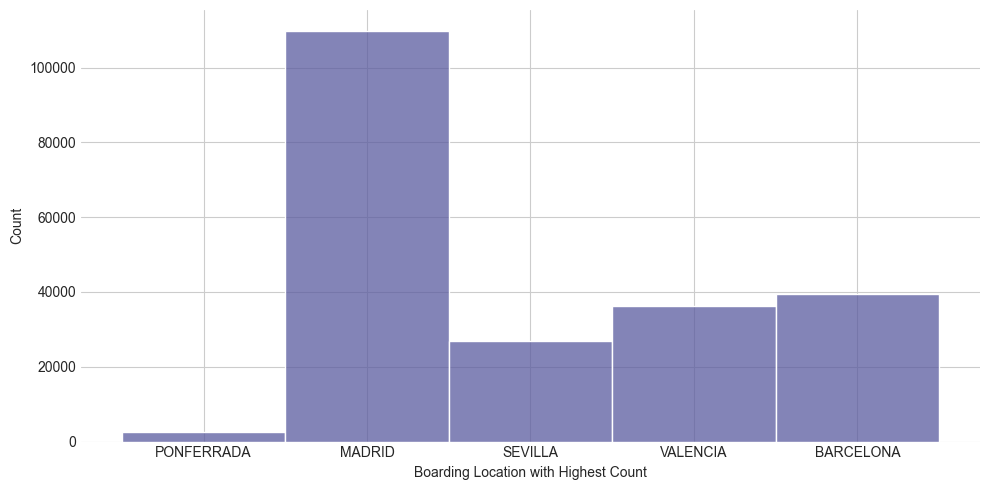

In [16]:
sns.displot(data=df, x='origin', aspect=2)

plt.xlabel("Boarding Location with Highest Count")

plt.show()

Checking destination with highest count

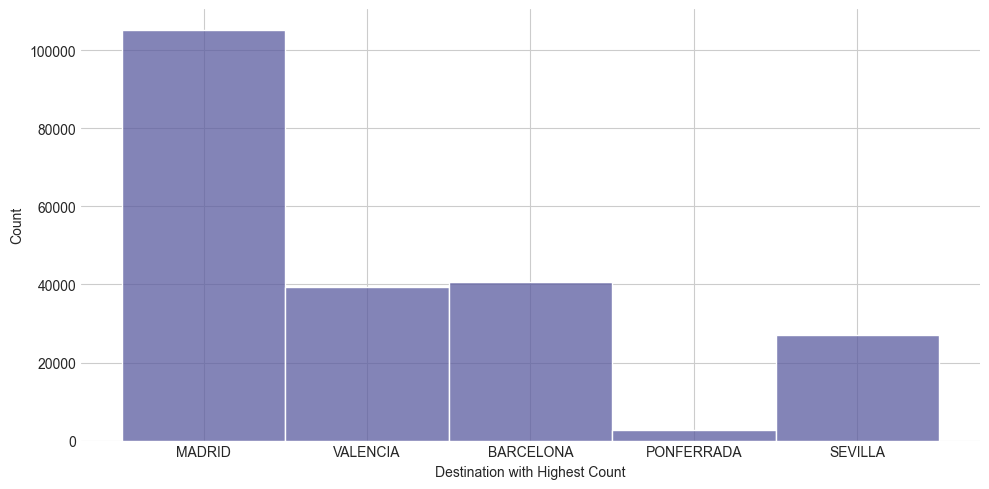

In [17]:
sns.displot(data=df, x='destination', aspect=2)

plt.xlabel("Destination with Highest Count")

plt.show()

Checking train type that runs the most

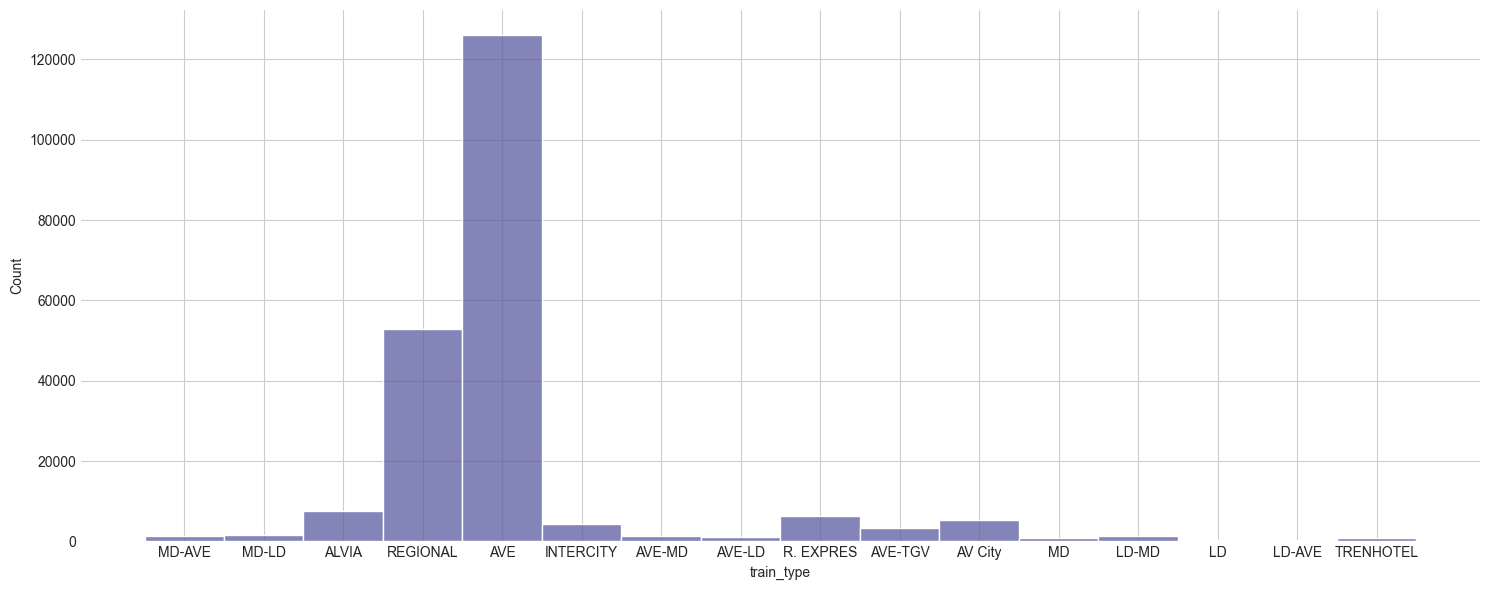

In [18]:
sns.displot(data=df, x='train_type', height=6, aspect=2.5)

plt.show()

Checking most used train class

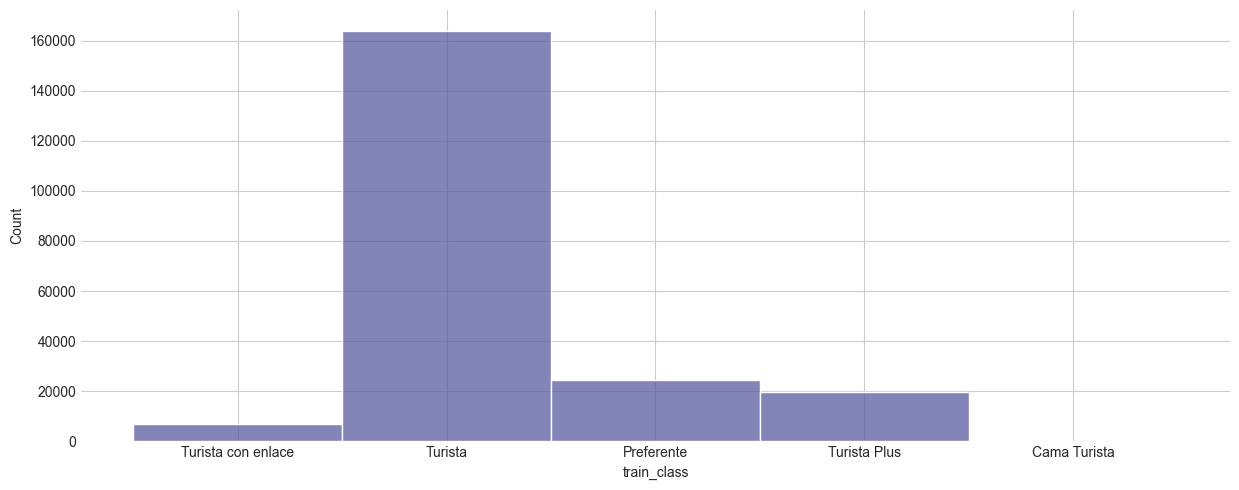

In [19]:
sns.displot(data=df, x='train_class', height=5, aspect=2.5)

plt.show()

Checking price of tickets for train type and class

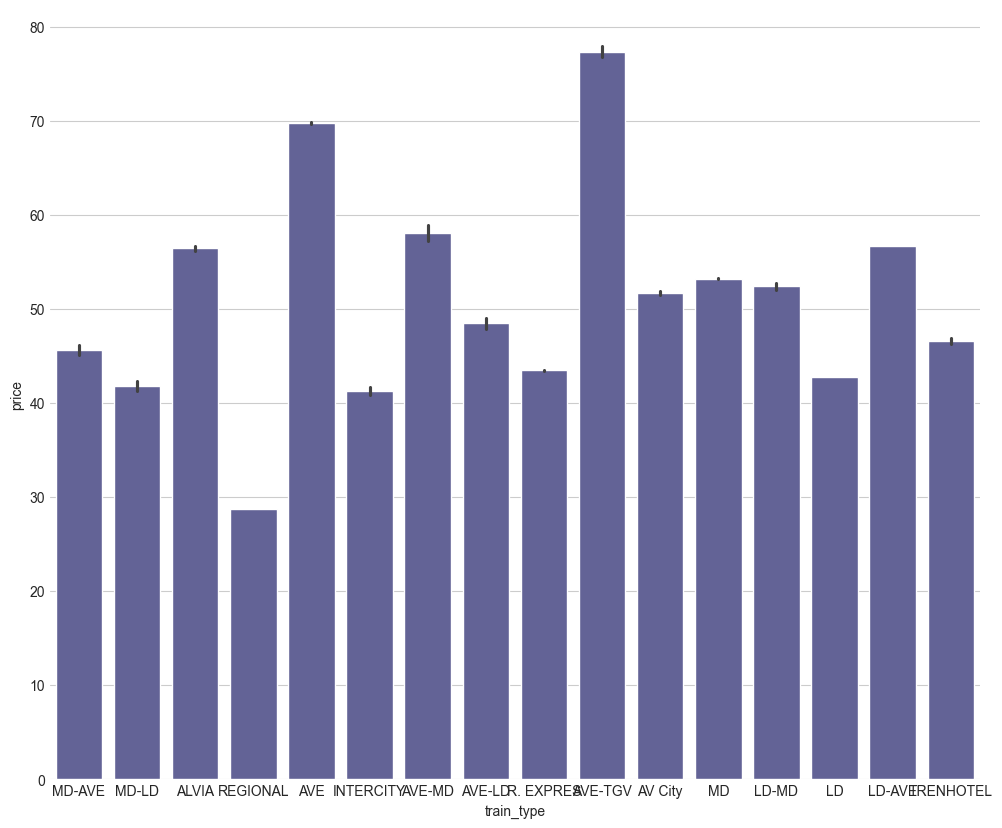

In [20]:
plt.figure(figsize=(12, 10))

sns.barplot(data=df, x='train_type', y='price')

plt.show()

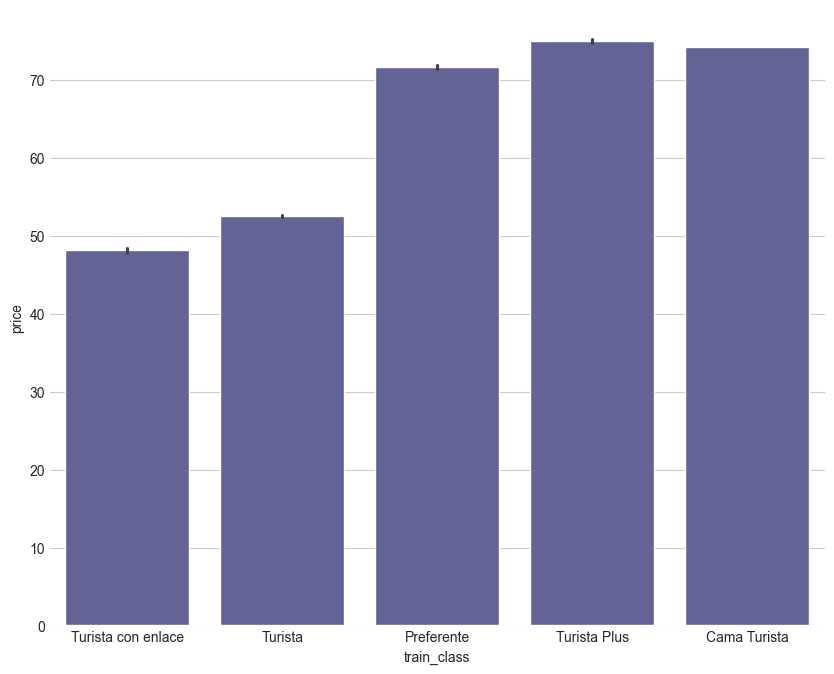

In [21]:
plt.figure(figsize=(10, 8))

sns.barplot(data=df, x='train_class', y='price')

plt.show()

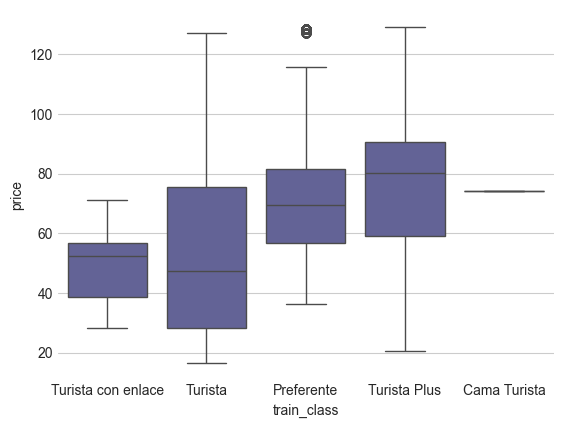

In [22]:
sns.boxplot(data=df, x='train_class', y='price')

plt.show()

## Machine Learning

In [23]:
encoder = LabelEncoder()

In [24]:
df.head()

,origin,destination,start_date,end_date,train_type,price,train_class,fare
0,PONFERRADA,MADRID,2019-06-02 15:00:00,2019-06-02 19:42:00,MD-AVE,59.50,Turista con enlace,Flexible
1,PONFERRADA,MADRID,2019-06-02 17:15:00,2019-06-02 23:03:00,MD-AVE,34.65,Turista con enlace,Promo +
2,PONFERRADA,MADRID,2019-06-02 17:15:00,2019-06-02 23:10:00,MD-LD,39.95,Turista con enlace,Promo +
3,PONFERRADA,MADRID,2019-06-02 17:15:00,2019-06-02 22:14:00,MD-AVE,40.60,Turista con enlace,Promo +
4,PONFERRADA,MADRID,2019-06-02 18:55:00,2019-06-02 23:03:00,ALVIA,27.90,Turista,Promo


In [25]:
df_pred = df.copy()
df_pred = df.drop(['start_date', 'end_date', 'price'], axis=1)

In [26]:
df['origin'] = encoder.fit_transform(df['origin'])
df['destination'] = encoder.fit_transform(df['destination'])
df['train_type'] = encoder.fit_transform(df['train_type'])
df['train_class'] = encoder.fit_transform(df['train_class'])
df['fare'] = encoder.fit_transform(df['fare'])

df = df.drop(['start_date', 'end_date'], axis=1)

In [27]:
df.head()

,origin,destination,train_type,price,train_class,fare
0,2,1,11,59.50,4,1
1,2,1,11,34.65,4,4
2,2,1,12,39.95,4,4
3,2,1,11,40.60,4,4
4,2,1,0,27.90,2,3


In [28]:
X = df.drop(['price'], axis=1)
y = df['price']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
lr = LinearRegression()

In [31]:
lr.fit(X_train, y_train)

LinearRegression()

In [32]:
y_pred = lr.predict(X_test)

In [33]:
r2_score(y_test, y_pred)

0.7211169663872092

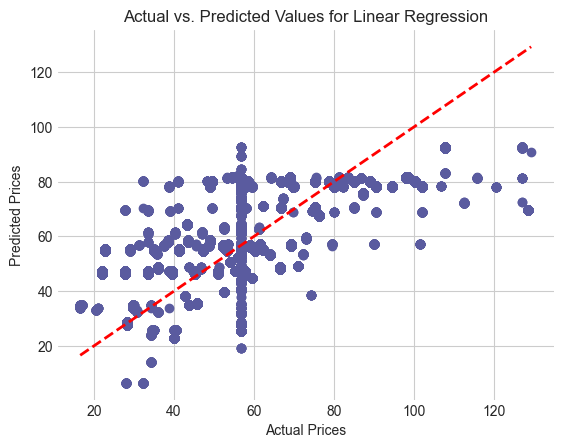

R-squared Score: 0.72


In [34]:
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.title('Actual vs. Predicted Values for Linear Regression')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()

# Print R-squared score
r2 = r2_score(y_test, y_pred)
print(f'R-squared Score: {r2:.2f}')

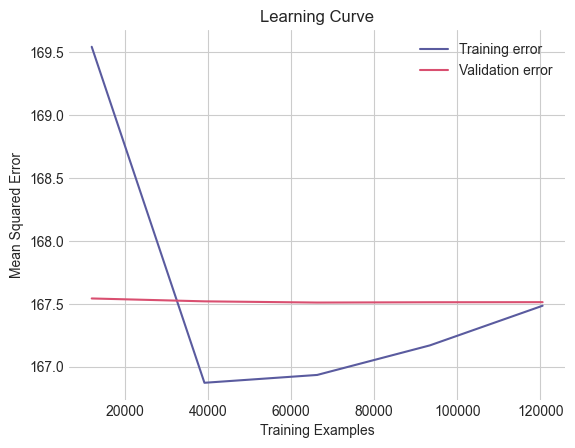

In [35]:
lr = LinearRegression()

# Function to plot the learning curve
def plot_learning_curve(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='neg_mean_squared_error')

    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    plt.plot(train_sizes, train_scores_mean, label='Training error')
    plt.plot(train_sizes, test_scores_mean, label='Validation error')
    
    plt.xlabel('Training Examples')
    plt.ylabel('Mean Squared Error')
    plt.title('Learning Curve')
    plt.legend()
    plt.show()

# Plot learning curve for the linear regression model
plot_learning_curve(lr, X_train, y_train)

Trying to improve score with XGBoost Regressor

In [36]:
xgbr = xgb.XGBRegressor()

In [37]:
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [38]:
y_pred = xgbr.predict(X_test)

In [39]:
r2_score(y_test, y_pred)

0.8435823570132146

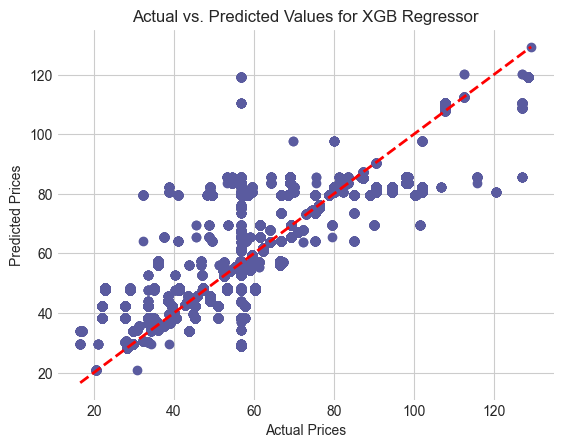

R-squared Score: 0.84


In [40]:
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.title('Actual vs. Predicted Values for XGB Regressor')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()

# Print R-squared score
r2 = r2_score(y_test, y_pred)
print(f'R-squared Score: {r2:.2f}')

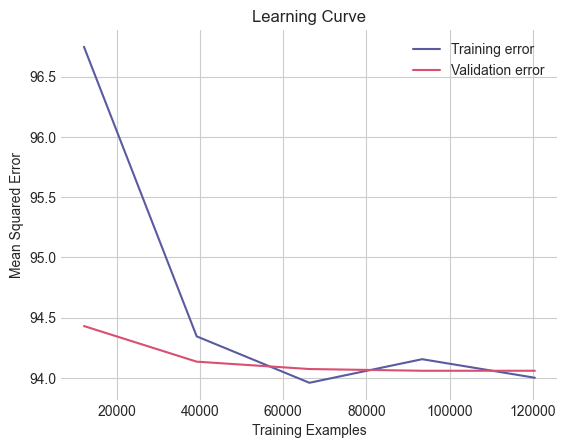

In [41]:
def plot_learning_curve(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='neg_mean_squared_error')

    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    plt.plot(train_sizes, train_scores_mean, label='Training error')
    plt.plot(train_sizes, test_scores_mean, label='Validation error')
    
    plt.xlabel('Training Examples')
    plt.ylabel('Mean Squared Error')
    plt.title('Learning Curve')
    plt.legend()
    plt.show()

plot_learning_curve(xgbr, X_train, y_train)

Using the model on real-life data example

In [42]:
df_pred.head()

,origin,destination,train_type,train_class,fare
0,PONFERRADA,MADRID,MD-AVE,Turista con enlace,Flexible
1,PONFERRADA,MADRID,MD-AVE,Turista con enlace,Promo +
2,PONFERRADA,MADRID,MD-LD,Turista con enlace,Promo +
3,PONFERRADA,MADRID,MD-AVE,Turista con enlace,Promo +
4,PONFERRADA,MADRID,ALVIA,Turista,Promo


Data sample

<center>

| Traveler | Origin    | Destination | Train Type | Train Class   | Fare           |
|:--------:|:---------:|:-----------:|:----------:|:-------------:|:--------------:|
|    1     |  Madrid   |   Sevilla    |    AVE     |    Turista    |    Promo       |
|    2     | Barcelona |  Barcelona   |    AVE     |  Preferente   |   Flexible     |
|    3     |  Sevilla  | Ponferrada   |   Alvia    | Turista Plus  |   Promo +      |

</center>

Checking enconding mappings to make data for real-life prediction example

In [43]:
for column in df_pred.columns:
    if df_pred[column].dtype == 'object':
        le = LabelEncoder()
        df_pred[column] = le.fit_transform(df_pred[column])
        
        print(f"{column} Encoding Mapping:")
        print(dict(zip(le.classes_, le.transform(le.classes_))))
        print()

origin Encoding Mapping:
{'BARCELONA': 0, 'MADRID': 1, 'PONFERRADA': 2, 'SEVILLA': 3, 'VALENCIA': 4}

destination Encoding Mapping:
{'BARCELONA': 0, 'MADRID': 1, 'PONFERRADA': 2, 'SEVILLA': 3, 'VALENCIA': 4}

train_type Encoding Mapping:
{'ALVIA': 0, 'AV City': 1, 'AVE': 2, 'AVE-LD': 3, 'AVE-MD': 4, 'AVE-TGV': 5, 'INTERCITY': 6, 'LD': 7, 'LD-AVE': 8, 'LD-MD': 9, 'MD': 10, 'MD-AVE': 11, 'MD-LD': 12, 'R. EXPRES': 13, 'REGIONAL': 14, 'TRENHOTEL': 15}

train_class Encoding Mapping:
{'Cama Turista': 0, 'Preferente': 1, 'Turista': 2, 'Turista Plus': 3, 'Turista con enlace': 4}

fare Encoding Mapping:
{'Adulto ida': 0, 'Flexible': 1, 'Mesa': 2, 'Promo': 3, 'Promo +': 4}



Using respective mappings to complete data for our predictions

In [44]:
price_check = ([[1, 3, 2, 2, 3],
                [0, 0, 2, 1, 1],
                [3, 2, 0, 3, 4]])

for i, prediction in enumerate(xgbr.predict(price_check)):
    print("Predicted ticket price for Traveler {} is: {:.2f}".format(i+1, prediction))

Predicted ticket price for Traveler 1 is: 48.43
Predicted ticket price for Traveler 2 is: 109.85
Predicted ticket price for Traveler 3 is: 43.83
